# References

###  For more info on SHAP (SHapley Additive exPlanations) see

- https://github.com/slundberg/shap
- http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions
- https://christophm.github.io/interpretable-ml-book/shapley.html

### More about Plotly Dash

- https://dash.plot.ly/

# Read Data

In [4]:
import pandas as pd

feature_names=["Age", "Workclass", "Final Weight", "Education", "Education-Num", "Marital Status",
               "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
               "Hours per week", "Country", "Income"]

df_train=pd.read_csv("../../data/adult.data",
                     names=feature_names)

df_test=pd.read_csv("../../data/adult.test",
                    skiprows =1,
                    names=feature_names)



# Data prep & problem definition

In [5]:
def df_prep(df):    
    LABEL="Income"
    y_train=df[LABEL].replace([" <=50K"," <=50K."," >50K"," >50K."],[0,0,1,1])
    df_X=df.drop(LABEL, axis=1)
    return df_X,y_train

df_X_train,y_train=df_prep(df_train)
df_X_test,y_test=df_prep(df_test)

# Load trained model

## Load with joblib

In [6]:
import os
import joblib

def load_model(model_id):
    
    load_path=f"../../models/{model_id}.pickle"
    return joblib.load(load_path)
   
model=load_model("adult_randomforest")
model


Pipeline(memory=None,
     steps=[('featurize', DataFrameMapper(default=False, df_out=True,
        features=[(['Age'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0), {}), (['Final Weight'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0), {}), (['Education-Num'], Im...imators=500, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])

## Check model is working!

In [7]:
from sklearn.metrics import roc_curve, auc

y_score = model.predict_proba(df_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,y_score)
roc_auc= auc(fpr, tpr)
print("roc_auc",roc_auc)

assert roc_auc>=.85,"something is wrong, check that score, auc<.8"

roc_auc 0.8972048306942328


# Calculate Shapley values

## Get transformed feature values/matrix

In [8]:
import sklearn
from copy import deepcopy

# Split pipeline & classifier, allowing Shap to use fast tree method
# *Work in progress* - could we bypass this? Let me know!

model_prep=deepcopy(model)
model_clf=model_prep.steps.pop()[1]

# Using 100 rows, just for quick testing
# more rows add more detail to shap explanations
SAMPLE_ROWS=100

df_explanation=df_test.sample(SAMPLE_ROWS)

# Get transformed set from raw data (shap will need it instead of raw data)
X_explanation_rows=model_prep.transform(df_explanation)
X_explanation_rows


,Age,Final Weight,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_ ?,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
4051,45.0,163174.0,7.0,4386.0,0.0,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4005,19.0,497414.0,4.0,0.0,0.0,35.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1621,61.0,39128.0,9.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12667,47.0,122206.0,9.0,0.0,0.0,20.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9905,45.0,188694.0,15.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11567,26.0,259138.0,7.0,2407.0,0.0,36.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6498,60.0,227232.0,9.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1298,17.0,129396.0,7.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10596,51.0,194995.0,14.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
447,27.0,95108.0,13.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
import shap

feature_names=X_explanation_rows.columns.values

# use fast shapley tree explainer
shap_explainer=shap.TreeExplainer(model_clf)
shap_values = shap_explainer.shap_values(X_explanation_rows)

# Use [1] (true label is in index 1, get that)
shap_values=shap_values[1]

# can take a while depending on cores/proc speed
# 100 rows on i5 laptop, for this dataset, ~ 10 secs

# Data prep for explanations & Dash

In [10]:
# Some columns that help on table sorting, filtering, etc

df_explanation["SCORE_PROB"]=model_clf.predict_proba(X_explanation_rows)[:,1]

# Use baseline probability from shap_explainer to create ratio to base rate
df_explanation["SCORE_RATIO"]=df_explanation.SCORE_PROB/shap_explainer.expected_value[1]

# Just because...
df_explanation[["SCORE_PROB","SCORE_RATIO"]]=df_explanation[["SCORE_PROB","SCORE_RATIO"]].round(2)
df_explanation


,Age,Workclass,Final Weight,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Income,SCORE_PROB,SCORE_RATIO
4051,45,Private,163174,11th,7,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,4386,0,40,United-States,>50K.,0.53,1.05
4005,19,?,497414,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Female,0,0,35,Mexico,<=50K.,0.14,0.27
1621,61,Self-emp-not-inc,39128,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,35,United-States,<=50K.,0.57,1.13
12667,47,Local-gov,122206,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,20,United-States,>50K.,0.55,1.11
9905,45,Self-emp-inc,188694,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,>50K.,0.83,1.67
11567,26,Private,259138,11th,7,Married-civ-spouse,Other-service,Wife,White,Female,2407,0,36,United-States,<=50K.,0.37,0.73
6498,60,Local-gov,227232,HS-grad,9,Widowed,Exec-managerial,Unmarried,White,Female,0,0,40,United-States,<=50K.,0.28,0.56
1298,17,Private,129396,11th,7,Never-married,Sales,Other-relative,White,Female,0,0,26,United-States,<=50K.,0.09,0.18
10596,51,Private,194995,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K.,0.82,1.65
447,27,Private,95108,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,<=50K.,0.30,0.59


In [11]:
# Cast calculated shap values as dataframe, to use index based getters later on
df_shap_values=pd.DataFrame(shap_values,columns=feature_names)
df_shap_values.index=X_explanation_rows.index

# Add top N positive/negative features to each row (this allows table search, which is cool) 
N=5

topN=df_shap_values.apply(lambda s: ",".join(s.nlargest(N).index.tolist()), axis=1)
bottomN=df_shap_values.apply(lambda s: ",".join(s.nsmallest(N).index.tolist()), axis=1)

df_explanation["TOP_POS"]=topN.values
df_explanation["TOP_NEG"]=bottomN.values

df_explanation

,Age,Workclass,Final Weight,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Income,SCORE_PROB,SCORE_RATIO,TOP_POS,TOP_NEG
4051,45,Private,163174,11th,7,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,4386,0,40,United-States,>50K.,0.53,1.05,"Marital Status_ Married-civ-spouse,Relationshi...","Education-Num,Education_ 11th,Occupation_ Mach..."
4005,19,?,497414,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Female,0,0,35,Mexico,<=50K.,0.14,0.27,"Marital Status_ Never-married,Relationship_ Ow...","Marital Status_ Married-civ-spouse,Age,Relatio..."
1621,61,Self-emp-not-inc,39128,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,35,United-States,<=50K.,0.57,1.13,"Marital Status_ Married-civ-spouse,Relationshi...","Education-Num,Hours per week,Education_ HS-gra..."
12667,47,Local-gov,122206,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,20,United-States,>50K.,0.55,1.11,"Marital Status_ Married-civ-spouse,Relationshi...","Hours per week,Education-Num,Education_ HS-gra..."
9905,45,Self-emp-inc,188694,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,>50K.,0.83,1.67,"Education-Num,Marital Status_ Married-civ-spou...","Capital Gain,Occupation_ Exec-managerial,Educa..."
11567,26,Private,259138,11th,7,Married-civ-spouse,Other-service,Wife,White,Female,2407,0,36,United-States,<=50K.,0.37,0.73,"Marital Status_ Married-civ-spouse,Relationshi...","Age,Occupation_ Other-service,Education-Num,Re..."
6498,60,Local-gov,227232,HS-grad,9,Widowed,Exec-managerial,Unmarried,White,Female,0,0,40,United-States,<=50K.,0.28,0.56,"Occupation_ Exec-managerial,Marital Status_ Ne...","Marital Status_ Married-civ-spouse,Relationshi..."
1298,17,Private,129396,11th,7,Never-married,Sales,Other-relative,White,Female,0,0,26,United-States,<=50K.,0.09,0.18,"Relationship_ Own-child,Education_ HS-grad,Occ...","Marital Status_ Married-civ-spouse,Age,Marital..."
10596,51,Private,194995,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K.,0.82,1.65,"Education-Num,Marital Status_ Married-civ-spou...","Capital Gain,Education_ Bachelors,Occupation_ ..."
447,27,Private,95108,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,<=50K.,0.30,0.59,"Education-Num,Occupation_ Prof-specialty,Educa...","Marital Status_ Married-civ-spouse,Age,Marital..."


## Let's check! local reason codes

,4051
TOP_POS,"Marital Status_ Married-civ-spouse,Relationship_ Husband,Marital Status_ Never-married,Age,Sex"
TOP_NEG,"Education-Num,Education_ 11th,Occupation_ Machine-op-inspct,Hours per week,Occupation_ Exec-managerial"


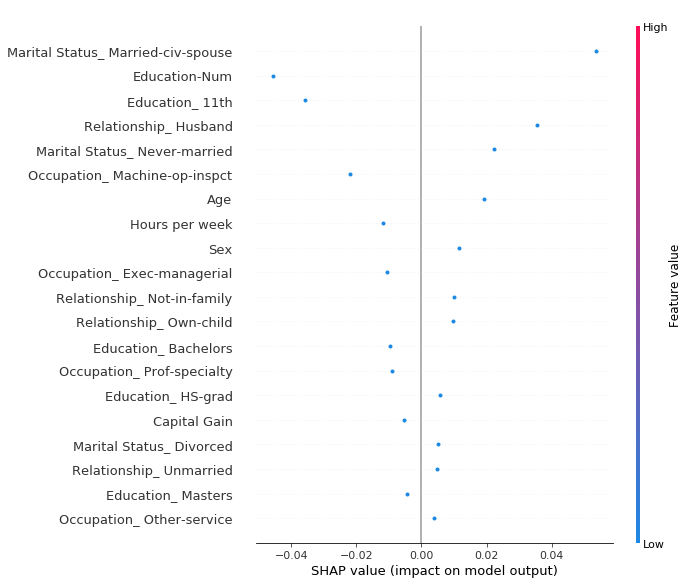

In [12]:
# Check shapley values (first row)
index=df_shap_values.index[0]
from IPython.display import display

pd.set_option('display.max_colwidth', 200)
display(df_explanation[["TOP_POS","TOP_NEG"]].loc[[index]].T)

shap.summary_plot(df_shap_values.loc[[index]].values,
                  X_explanation_rows.loc[[index]].values,
                  feature_names=feature_names)



## Global Shapley importances

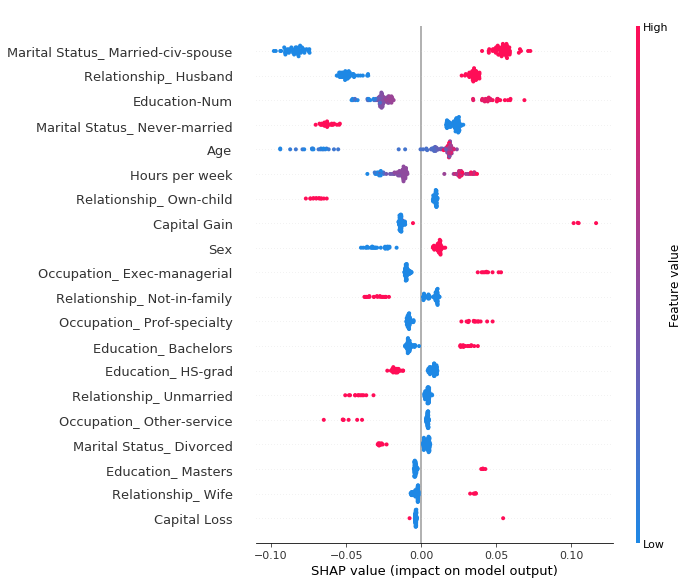

In [13]:
shap.summary_plot(df_shap_values.values, X_explanation_rows,feature_names=feature_names)

# Prepare dataframe for Dash

In [14]:
# Add index, we'll use it on dash back & forward (hidden)
df_explanation["index"]=df_explanation.index.values
df_explanation

,Age,Workclass,Final Weight,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Income,SCORE_PROB,SCORE_RATIO,TOP_POS,TOP_NEG,index
4051,45,Private,163174,11th,7,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,4386,0,40,United-States,>50K.,0.53,1.05,"Marital Status_ Married-civ-spouse,Relationship_ Husband,Marital Status_ Never-married,Age,Sex","Education-Num,Education_ 11th,Occupation_ Machine-op-inspct,Hours per week,Occupation_ Exec-managerial",4051
4005,19,?,497414,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Female,0,0,35,Mexico,<=50K.,0.14,0.27,"Marital Status_ Never-married,Relationship_ Own-child,Education_ HS-grad,Relationship_ Unmarried,Workclass_ Private","Marital Status_ Married-civ-spouse,Age,Relationship_ Husband,Education-Num,Relationship_ Not-in-family",4005
1621,61,Self-emp-not-inc,39128,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,35,United-States,<=50K.,0.57,1.13,"Marital Status_ Married-civ-spouse,Relationship_ Husband,Marital Status_ Never-married,Age,Sex","Education-Num,Hours per week,Education_ HS-grad,Capital Gain,Occupation_ Exec-managerial",1621
12667,47,Local-gov,122206,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,20,United-States,>50K.,0.55,1.11,"Marital Status_ Married-civ-spouse,Relationship_ Husband,Marital Status_ Never-married,Age,Sex","Hours per week,Education-Num,Education_ HS-grad,Capital Gain,Occupation_ Exec-managerial",12667
9905,45,Self-emp-inc,188694,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,>50K.,0.83,1.67,"Education-Num,Marital Status_ Married-civ-spouse,Education_ Prof-school,Occupation_ Prof-specialty,Relationship_ Husband","Capital Gain,Occupation_ Exec-managerial,Education_ Bachelors,Capital Loss,Education_ Masters",9905
11567,26,Private,259138,11th,7,Married-civ-spouse,Other-service,Wife,White,Female,2407,0,36,United-States,<=50K.,0.37,0.73,"Marital Status_ Married-civ-spouse,Relationship_ Wife,Marital Status_ Never-married,Relationship_ Own-child,Relationship_ Not-in-family","Age,Occupation_ Other-service,Education-Num,Relationship_ Husband,Education_ 11th",11567
6498,60,Local-gov,227232,HS-grad,9,Widowed,Exec-managerial,Unmarried,White,Female,0,0,40,United-States,<=50K.,0.28,0.56,"Occupation_ Exec-managerial,Marital Status_ Never-married,Age,Relationship_ Own-child,Relationship_ Not-in-family","Marital Status_ Married-civ-spouse,Relationship_ Unmarried,Relationship_ Husband,Sex,Education-Num",6498
1298,17,Private,129396,11th,7,Never-married,Sales,Other-relative,White,Female,0,0,26,United-States,<=50K.,0.09,0.18,"Relationship_ Own-child,Education_ HS-grad,Occupation_ Other-service,Relationship_ Unmarried,Marital Status_ Divorced","Marital Status_ Married-civ-spouse,Age,Marital Status_ Never-married,Relationship_ Husband,Education-Num",1298
10596,51,Private,194995,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K.,0.82,1.65,"Education-Num,Marital Status_ Married-civ-spouse,Occupation_ Exec-managerial,Education_ Masters,Relationship_ Husband","Capital Gain,Education_ Bachelors,Occupation_ Prof-specialty,Capital Loss,Relationship_ Wife",10596
447,27,Private,95108,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,40,United-States,<=50K.,0.30,0.59,"Education-Num,Occupation_ Prof-specialty,Education_ Bachelors,Relationship_ Own-child,Sex","Marital Status_ Married-civ-spouse,Age,Marital Status_ Never-married,Relationship_ Husband,Relationship_ Not-in-family",447


# Dash 

In [15]:
import os
from IPython.display import display,display_html
# From awesome dash intro repo by Kevin Mader
# A quick intro to Dash made for the PyData event in Zurich
# https://github.com/4QuantOSS/DashIntro 

# Can use Jupyter nbserverproxy extension (available at /.../proxy/<port>)

def show_app(app, port = 10001, 
             width = 700, 
             height = 350, 
             offline = False,
            in_binder = None):
    in_binder ='JUPYTERHUB_SERVICE_PREFIX' in os.environ if in_binder is None else in_binder
    if in_binder:
        base_prefix = '{}proxy/{}/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)
        url = 'https://hub.mybinder.org{}'.format(base_prefix)
        app.config.requests_pathname_prefix = base_prefix
    else:
        url = 'http://localhost:%d' % port
    iframe = '<a href="{url}" target="_new">Open in new window</a><hr><iframe src="{url}" width={width} height={height}></iframe>'.format(url = url, 
                                                                                  width = width, 
                                                                                  height = height)

    iframe = '<a href="{url}" target="_new">Open in new window</a><hr>'.format(url = url, 
                                                                                  width = width, 
                                                                                  height = height)

    display_html(iframe, raw = True)
    if offline:
        app.css.config.serve_locally = True
        app.scripts.config.serve_locally = True
        
    return app.run_server(debug=False, # needs to be false in Jupyter
                          host = '0.0.0.0',
                          port=port)

In [16]:
import sklearn.metrics as metrics
import plotly.graph_objs as go

def shap_local_importances(row_index,max_features=10):
    X_shap=X_explanation_rows.loc[[row_index],:]
    
    shap_values=df_shap_values.loc[[row_index]].values
    
    index=0

    # Create more friendly X axis, like feature=<feature value for that record>
    feature_names=X_shap.columns+"="+X_shap.iloc[[index],:].T.iloc[:,0].values.round(4).astype("str")
    
    df_row_shap=pd.DataFrame(shap_values[0,:],feature_names).reset_index()
    df_row_shap.columns=["feature","shapley"]
    df_row_shap["custom_data"]=X_shap.columns+"|"+str(row_index)
    df_row_shap["abs_shapley"]=df_row_shap.shapley.abs()
    df_row_shap.sort_values("abs_shapley",ascending=False,inplace=True)
    
    # Need to check plotly how to reverse axis, hacking for now, sorry!
    df_top_features=df_row_shap.head(max_features).sort_values("abs_shapley",ascending=True)
    
    figure={
            'data': [
                {
                    'x':  df_top_features.shapley.values,
                    'y': df_top_features.feature.values,
                    'customdata': df_top_features.custom_data.values,
                    'name': 'Local reason codes',
                    'mode': 'markers',
                    'marker': {'size': 10}
                }
            ],
            'layout':{
                "autosize":False,
                    "width":370,
                    "height":450,
                    "margin":go.Margin(
                        l=150,
                        r=50,
                        b=40,
                        t=0,
                      #  pad=50
                  ),
            }
        }
        
    figure = go.Figure(figure)
        
    return figure

# Test
shap_local_importances(X_explanation_rows.index[0])

{'data': [{'type': 'scatter',
   'x': array([-0.01045631,  0.01163903, -0.01176324,  0.01919949, -0.02199642,
           0.02239052,  0.03564968, -0.03569694, -0.04551694,  0.05355513]),
   'y': array(['Occupation_ Exec-managerial=0.0', 'Sex=1.0',
          'Hours per week=40.0', 'Age=45.0',
          'Occupation_ Machine-op-inspct=1.0',
          'Marital Status_ Never-married=0.0', 'Relationship_ Husband=1.0',
          'Education_ 11th=1.0', 'Education-Num=7.0',
          'Marital Status_ Married-civ-spouse=1.0'], dtype=object),
   'customdata': array(['Occupation_ Exec-managerial|4051', 'Sex|4051',
          'Hours per week|4051', 'Age|4051',
          'Occupation_ Machine-op-inspct|4051',
          'Marital Status_ Never-married|4051', 'Relationship_ Husband|4051',
          'Education_ 11th|4051', 'Education-Num|4051',
          'Marital Status_ Married-civ-spouse|4051'], dtype=object),
   'name': 'Local reason codes',
   'mode': 'markers',
   'marker': {'size': 10}}],
 'layout':

In [17]:
import sklearn.metrics as metrics
import plotly.graph_objs as go

def shap_detail(row_index,feature):
    feature_shapley_values = df_shap_values[feature].values
    feature_values = X_explanation_rows[feature].values
    
    #friendly title feature=<feature value for that row>
    title="{0}={1}".format(feature,X_explanation_rows.loc[row_index][feature])
    
    figure={
            # All data points here
            'data': [

                {
                    'x':  feature_values,
                    'y': feature_shapley_values,
                    'name': 'Trace 1',
                    'mode': 'markers',
                    'marker': {'size': 5}
                },
                
                
            ],
            # Add annotation to highlight current feature value & position
            'layout':{
                "annotations":[
                        dict(
                            x=X_explanation_rows.loc[row_index][feature],
                            y=df_shap_values.loc[row_index][feature],
                            xref='x',
                            yref='y',
                            text=title,
                            showarrow=True,
                            arrowhead=7,
                            ax=0,
                            ay=-40,
                            bgcolor="red"
                        )
                    ],
                 #"title":title,
                "autosize":False,
                    "width":250,
                    "height":420,
                    "margin":go.Margin(
                        l=20,
                        r=10,
                        b=80,
                        t=20,
                        pad=60
                  ),
            },
            
        }
        
    figure = go.Figure(figure)
        
    return figure

# Test
shap_detail(X_explanation_rows.index[0],"Age")

{'data': [{'type': 'scatter',
   'x': array([45., 19., 61., 47., 45., 26., 60., 17., 51., 27., 47., 35., 54.,
          40., 47., 19., 42., 47., 22., 31., 43., 45., 51., 25., 27., 56.,
          54., 64., 30., 48., 54., 23., 43., 33., 29., 51., 53., 41., 26.,
          21., 36., 49., 22., 29., 32., 44., 29., 45., 30., 28., 42., 41.,
          33., 27., 33., 72., 50., 31., 26., 37., 27., 72., 38., 26., 27.,
          35., 21., 28., 37., 51., 38., 35., 39., 32., 52., 63., 30., 81.,
          29., 34., 59., 63., 43., 24., 30., 36., 41., 45., 50., 34., 50.,
          55., 33., 29., 52., 40., 50., 34., 22., 19.]),
   'y': array([ 0.01919949, -0.06677689,  0.01957402,  0.01963303,  0.01844421,
          -0.06306359,  0.01759369, -0.07264378,  0.01861418, -0.07906827,
           0.01853436,  0.01306553,  0.01980514,  0.0173547 ,  0.02143173,
          -0.0939071 ,  0.01974251,  0.01702301, -0.0938905 ,  0.00831319,
           0.0205374 ,  0.01834302,  0.01928656, -0.08729359, -0.05811549,
   

In [18]:
import dash
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html
import dash_table_experiments as dt
import plotly


APP_NAME='SHAP Dash! Explanations on Dash - DevScope AI Lab'
app = dash.Dash(name=APP_NAME)

# Need this because we'll add some dynamic callbacks
app.config['suppress_callback_exceptions'] = True

# Hide index column
visible_cols=df_explanation.columns.drop(["index"]).values

# Reference: https://github.com/plotly/dash-svm/
external_css = [
    # Normalize the CSS
    "https://cdnjs.cloudflare.com/ajax/libs/normalize/7.0.0/normalize.min.css",
    # Fonts
    "https://fonts.googleapis.com/css?family=Open+Sans|Roboto",
    "https://maxcdn.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css",
    # Base Stylesheet, replace this with your own base-styles.css using Rawgit
    "https://rawgit.com/xhlulu/9a6e89f418ee40d02b637a429a876aa9/raw/f3ea10d53e33ece67eb681025cedc83870c9938d/base-styles.css",
    # Custom Stylesheet, replace this with your own custom-styles.css using Rawgit
    "https://cdn.rawgit.com/plotly/dash-svm/bb031580/custom-styles.css"
    #"https://gist.githubusercontent.com/rquintino/f67a1e9f2c13b9b3e0dae35ac6477295/raw/aa6d5c068882584ab2a019c510c32df80fd8c352/shap-dash-custom-styles.css"
]

for css in external_css:
    app.css.append_css({"external_url": css})
    
    
app.layout = html.Div([
    # Reference: https://github.com/plotly/dash-svm/
    # .container class is fixed, .container.scalable is scalable
    html.Div(className="banner", children=[
        html.Div(className='container scalable', children=[
            html.H2(html.A(
                APP_NAME,
                href='https://github.com/DevScope/ai-lab',
                style={
                    'text-decoration': 'none',
                    'color': 'inherit'
                }
            )),

            html.A(
                html.Img(src="https://s3-us-west-1.amazonaws.com/plotly-tutorials/logo/new-branding/dash-logo-by-plotly-stripe-inverted.png"),
                href='https://plot.ly/products/dash/'
            )
        ]),
    ]),
    html.Div(id='body', className='container scalable', children=[
         html.Div([
            html.Div(
                [
                    dt.DataTable(
                        rows=df_explanation.to_dict('records'),
                        editable=False,
                        sortable=True,
                        columns=visible_cols,
                        row_selectable=True,
                        filterable=True,
                        id='score_table'
                        ),
                    html.Button('Explain', id='explain'),
                    html.Button('Clear', id='clear'),
                ],className="five columns"),
             html.Div(
                 [
                        html.Div(id="output",children=[
                            # Needed to add this blank chart on startup, otherwise charts wouldnt load?
                            # Dash tables have similar issue
                            dcc.Graph(
                                id='example-graph',
                                figure={'data': [], 'layout': { }
                            }
                        ),
                        ],style={"padding":"20px"})
                   ],id="results",className="seven columns",style={'height':'500px','overflow-y': 'scroll'})
        ],className="row")
     ])
])

@app.callback(
   Output('score_table', 'selected_row_indices'),
   [Input("clear","n_clicks")])
def click_clear(n_clicks):
    return []

@app.callback(
   Output('output', 'children'),
   [Input("explain","n_clicks")],
    state=[
        State('score_table', 'rows'),
        State('score_table', 'selected_row_indices')
    ])
def explain_selected_rows(n_clicks,rows,selected_row_indices):
    # note: currently, the only way I know to get selected indexes
    # we have to send whole table back from browser to python kernel...
    # new table component is expected this summer by plotly team!
    # https://github.com/plotly/dash-table-experiments/issues/15
    if not rows or len(rows)==0 or not selected_row_indices or len(selected_row_indices)==0:
        return []
    
    selected_row_indices.sort()
    
    # Reconstruct dataframe with original indexes
    df_rows = pd.DataFrame(rows)
    df_rows.index=df_rows["index"]
    
    indexes=df_rows.iloc[selected_row_indices].index
    
    # Check selectd rows on notebook (debug)
    #display(df_rows.loc[indexes])
    
    children=[]
    
    MAX_FEATURES=12
    
    i=0
    for index in indexes:
        i=i+1
        original_index=int(index)
        
        original_row=df_explanation.loc[[original_index]]
        X_original_row=X_explanation_rows.loc[[original_index]]
        
        title=" Age {0} (#)".format(
                             original_row.Age.iloc[0],
                             i+1
                            )
        
        score="{0:.2%} Probability".format(
                             original_row.SCORE_PROB.iloc[0]
                            )
        
        children.append(html.Div([html.H6(title,className="six columns"),
                                 html.H6(score,className="six columns",style={"text-align":"right"})
                                 ],className="row"))
        
        fig_shap=shap_local_importances(original_index,MAX_FEATURES)  
        
        children.append(html.Div([dcc.Graph(id='summary_'+str(i),figure=fig_shap,
                                            className="six columns",
                                            config={ 'displayModeBar': False}),
                                 html.Div(id="detail_"+str(i),className="six columns")
                                 ],className="row"))
    return children

# Ok... more than 100 and this won't work, have to dig deeper...
for i in range(100):    
    @app.callback(
        Output('detail_'+str(i), 'children'),
        [Input('summary_'+str(i), 'clickData')])
    def detail(clickData):
        if not clickData or len(clickData)==0:
            return []
        
        children=[]
        
        # Grab feature and row index from customdata, better way? let me know please.
        point=clickData["points"][0]
        
        feature,row_index=point["customdata"].split("|")
        row_index=int(row_index)
                                                        
        fig_shap=shap_detail(row_index,feature)  
        
        children.append(dcc.Graph(id='detail_chart_'+str(row_index),figure=fig_shap,
                                 config={ 'displayModeBar': False}))
        
        return children



In [19]:
# use <esc> i+i on Jupyter to quick interrupt & get control back to jupyter
show_app(app)


Open in new window

 * Running on http://0.0.0.0:10001/ (Press CTRL+C to quit)
127.0.0.1 - - [24/Aug/2018 23:28:12] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/Aug/2018 23:28:14] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [24/Aug/2018 23:28:14] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [24/Aug/2018 23:28:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [24/Aug/2018 23:28:15] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [24/Aug/2018 23:28:16] "GET /favicon.ico HTTP/1.1" 200 -
127.0.0.1 - - [24/Aug/2018 23:28:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [24/Aug/2018 23:28:20] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [24/Aug/2018 23:28:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [24/Aug/2018 23:28:22] "POST /_dash-update-component HTTP/1.1" 200 -
